In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
import math
import os
import csv
from itertools import chain
from pprint import pprint

### Rattle_Newton
import rattle_newton.sim_snake_tb as therma_sim

### Gradient Descent
from scipy.optimize import minimize

In [2]:
snakes_fp = 'raw_therma_data_2024_05_06.csv'
#snakes_fp = 'imp_therma_data_2024_05_06.csv'
snakes = pd.read_csv(snakes_fp)
snakes['Date'] = pd.to_datetime(snakes['Date'])
snakes['Year'] = snakes['Date'].dt.year
snakes['Month'] = snakes['Date'].dt.month
snakes['Day'] = snakes['Date'].dt.day
snakes['Hour'] = snakes['Date'].dt.hour
snakes['Minute'] = snakes['Date'].dt.minute

# Burn in
# snakes['Burnin_Set'] = 0
# snakes = pd.concat([snakes, snakes.assign(Burnin_Set=1)], ignore_index=True)
# snakes = snakes.dropna().sort_values(by=['Study_Site', 'Snake_Name', 'Burnin_Set', 'Date']).reset_index(drop=True)

## Filter out Winter
overwintering = [10, 11, 12, 1, 2, 3, 4]
filter_condition = ~snakes['Date'].dt.month.isin(overwintering)
snakes = snakes[filter_condition]
snakes = snakes.dropna().reset_index(drop=True)

snake_name = 'Eddie'
single_snake = snakes[snakes['Snake_Name']==snake_name].sort_values(['Date']).reset_index(drop=True) #'Burnin_Set',

single_snake.head(50)

,Date,Body,Study_Site,Snake_Name,Air,Burrow,Open,Shrub,Year,Month,Day,Hour,Minute
0,2022-07-01 00:40:01,15.595,Canada,Eddie,14.072,13.97950,11.1045,11.780000,2022,7,1,0,40
1,2022-07-01 01:50:01,14.093,Canada,Eddie,12.068,13.60350,10.3520,11.111000,2022,7,1,1,50
2,2022-07-01 03:00:01,13.091,Canada,Eddie,10.565,13.47825,9.8510,10.442000,2022,7,1,3,0
3,2022-07-01 04:10:01,12.090,Canada,Eddie,11.567,12.85150,9.3490,9.773000,2022,7,1,4,10
4,2022-07-01 05:20:01,11.088,Canada,Eddie,9.563,12.72625,8.8475,9.438667,2022,7,1,5,20
5,2022-07-01 06:30:01,10.587,Canada,Eddie,14.072,13.60325,11.1045,11.779667,2022,7,1,6,30
6,2022-07-01 07:40:01,11.589,Canada,Eddie,17.576,15.73250,19.3705,17.794000,2022,7,1,7,40
7,2022-07-01 08:50:01,17.097,Canada,Eddie,21.079,18.36050,31.3705,22.799667,2022,7,1,8,50
8,2022-07-01 10:00:01,29.100,Canada,Eddie,27.080,21.36075,38.1085,29.465000,2022,7,1,10,0
9,2022-07-01 11:10:01,33.097,Canada,Eddie,26.580,23.23500,41.5980,33.792333,2022,7,1,11,10


In [10]:
unique_snake_names_by_site = snakes.groupby('Study_Site')['Snake_Name'].agg(lambda x: list(set(x))).reset_index()
print(unique_snake_names_by_site['Snake_Name'][1])

['Horace', 'Ragnar']


In [28]:
# Define your simulator function
k=0.01
t_pref_max = 32 
t_pref_min = 18 
t_initial = 25
delta_t = 70
burrow_temp = single_snake['Burrow']
open_temp = single_snake['Open']
body_temp = single_snake['Body']


def cost_function(params, *covariates):
    t_pref_min, t_pref_max, t_opt = params[:3]
    burrow_temp, open_temp, k, delta_t, t_initial, body_temp = covariates
    
    ts = therma_sim.ThermalSimulator(flip_logic='preferred',
                                     t_pref_min=t_pref_min,
                                     t_pref_max=t_pref_max,
                                     t_pref_opt=t_opt, seed=42)
    ss_burrow_usage, simulated_temps = ts.tb_simulator_2_state_model_wrapper(
                        k=k,
                        t_initial=t_initial,
                        delta_t=delta_t,
                        burrow_temp_vector=burrow_temp,
                        open_temp_vector=open_temp,
                        return_tbody_sim=True)
    
    if t_pref_min >= t_pref_max:
        cost = np.mean((simulated_temps - body_temp)**2) * 100
    elif t_pref_min >= t_opt:
        cost = np.mean((simulated_temps - body_temp)**2) * 100
    elif t_pref_max <= t_opt:
        cost = np.mean((simulated_temps - body_temp)**2) * 100
    else:
        cost = np.mean((simulated_temps - body_temp)**2)
    return cost

# def gradient(params, *covariates):
#     k, t_pref_min, t_pref_max, t_opt = params[:4]
#     burrow_temp, open_temp, t_initial, body_temp = covariates
    
#     ts = therma_sim.ThermalSimulator(flip_logic='preferred',
#                                      t_pref_min=t_pref_min,
#                                      t_pref_max=t_pref_max,
#                                      t_pref_opt=t_opt, seed=42)
#     ss_burrow_usage, simulated_temps = ts.tb_simulator_2_state_model_wrapper(
#                         k=math.exp(k),
#                         t_initial=t_initial,
#                         burrow_temp_vector=burrow_temp,
#                         open_temp_vector=open_temp,
#                         return_tbody_sim=True)

#     dk = np.mean(2 * (simulated_temps - body_temp) * simulated_temps)
#     #ddbounce = np.mean(2 * (simulated_temps - body_temp))
#     dt_pref_min = np.mean(2 * (simulated_temps - body_temp) * (t_pref_min - simulated_temps))
#     dt_pref_max = np.mean(2 * (simulated_temps - body_temp) * (simulated_temps - t_pref_max))
#     dt_pref_opt = np.mean(2 * (simulated_temps - body_temp))
#     return np.array([dk, dt_pref_min, dt_pref_max, dt_pref_opt])

def gradient(params, *covariates):
    h=0.03 # Learning Rate
    grad_approx = np.zeros_like(params)
    for i in range(len(params)):
        # Create perturbed parameter vectors for both directions
        params_h_up = params.copy()
        params_h_down = params.copy()
        params_h_up[i] += h
        params_h_down[i] -= h
        
        # Calculate the function (e.g., loss) for both perturbed vectors
        loss_up = cost_function(params_h_up, *covariates)
        loss_down = cost_function(params_h_down, *covariates)
        
        # Approximate the gradient (partial derivative) for this parameter
        grad_approx[i] = (loss_up - loss_down) / (2 * h)
        
    return grad_approx

def adam_optimize(cost_function, grad_function, params, covariates, iterations=1000, alpha=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8, tol=1e-9):
    m = np.zeros_like(params)
    v = np.zeros_like(params)
    t = 0
    
    prev_cost = cost_function(params, *covariates)
    for i in range(1, iterations + 1):
        t += 1
        grad = grad_function(params, *covariates)
        m = beta1 * m + (1 - beta1) * grad
        v = beta2 * v + (1 - beta2) * (grad ** 2)
        m_hat = m / (1 - beta1 ** t)
        v_hat = v / (1 - beta2 ** t)
        params = params - alpha * m_hat / (np.sqrt(v_hat) + epsilon)
        
        cost = cost_function(params, *covariates)
        if np.abs(prev_cost - cost) < tol:
            print(f"Convergence reached at iteration {i}.")
            break
        prev_cost = cost

    return params

# Initial guess for parameters
initial_params = np.array([18, 32, 28], dtype=float)
covariates = (burrow_temp, open_temp, k, delta_t, t_initial, body_temp)
bounds = [(10, 40), (10, 40), (20,30)]

# Use optimization algorithm (e.g., minimize) to estimate parameters
result = minimize(cost_function, initial_params, args=covariates, jac=gradient, bounds=bounds, method='L-BFGS-B')
#result = adam_optimize(cost_function=cost_function, grad_function=gradient, params=initial_params, covariates=covariates)
# Print the estimated parameters
print("Estimated Parameters:", result)

Estimated Parameters:       fun: 19.93619739262465
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.        ,  1.07027698, -1.34137073])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 57
      nit: 7
     njev: 57
   status: 0
  success: True
        x: array([19.20402021, 27.48039258, 26.00008196])


In [7]:
print(result)

      fun: 33.1145852960411
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([-4.37656429e+01,  0.00000000e+00,  0.00000000e+00, -2.09946906e-02])
  message: 'ABNORMAL_TERMINATION_IN_LNSRCH'
     nfev: 43
      nit: 2
     njev: 43
   status: 2
  success: False
        x: array([1.21972145e-02, 1.80000044e+01, 3.20059760e+01, 2.80059804e+01])


In [19]:
help(result)

Help on OptimizeResult in module scipy.optimize.optimize object:

class OptimizeResult(builtins.dict)
 |  Represents the optimization result.
 |  
 |  Attributes
 |  ----------
 |  x : ndarray
 |      The solution of the optimization.
 |  success : bool
 |      Whether or not the optimizer exited successfully.
 |  status : int
 |      Termination status of the optimizer. Its value depends on the
 |      underlying solver. Refer to `message` for details.
 |  message : str
 |      Description of the cause of the termination.
 |  fun, jac, hess: ndarray
 |      Values of objective function, its Jacobian and its Hessian (if
 |      available). The Hessians may be approximations, see the documentation
 |      of the function in question.
 |  hess_inv : object
 |      Inverse of the objective function's Hessian; may be an approximation.
 |      Not available for all solvers. The type of this attribute may be
 |      either np.ndarray or scipy.sparse.linalg.LinearOperator.
 |  nfev, njev, nhe

In [7]:
float(result.x[0])

21.397516228300805

In [29]:
### Lets take a look
ts = therma_sim.ThermalSimulator(flip_logic='preferred',
                                     t_pref_min=result.x[0], #add result.x if using bgslas
                                     t_pref_max=result.x[1],
                                     t_pref_opt=result.x[2], seed=42)
ss_burrow_usage, simulated_temps = ts.tb_simulator_2_state_model_wrapper(
                    k=0.01,
                    t_initial=25,
                    delta_t=70,
                    burrow_temp_vector=single_snake['Burrow'],
                    open_temp_vector=single_snake['Open'],
                    return_tbody_sim=True)

In [30]:
cost = np.mean((simulated_temps - single_snake['Body'])**2)
print(cost)

19.93619739262465


<Axes: ylabel='Body'>

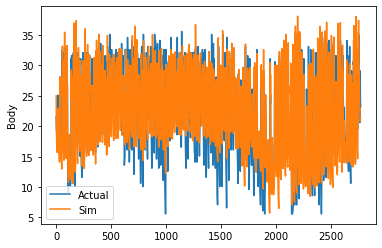

In [31]:
full_ts = len(single_snake['Date'])
# t_max =8000
# t_min = 7000
t_max = full_ts
t_min = 0
sns.lineplot(x=list(range(t_min,t_max)), y=single_snake['Body'][t_min:t_max], label='Actual')
sns.lineplot(x=list(range(t_min,t_max)) , y=simulated_temps[t_min:t_max], label='Sim')
#sns.lineplot(x=single_snake['Date'], y=single_snake['Burrow'][t_min:t_max], label='Actual')

## Collect Data on all Snakes

In [32]:
### Lets do this for all snakes
unique_snake_names = snakes['Snake_Name'].unique()
k=0.01
delta_t=70
t_pref_max = 32 
t_pref_min = 18 
t_initial = 25
t_opt = 28



data = []
for snake_name in unique_snake_names:
    single_snake = snakes[snakes['Snake_Name']==snake_name].sort_values(['Date']).reset_index(drop=True) #'Burnin_Set',
    snake_name = snake_name
    study_site = str(single_snake['Study_Site'].unique()[0])
    burrow_temp = single_snake['Burrow']
    open_temp = single_snake['Open']
    body_temp = single_snake['Body']
    covariates = (burrow_temp, open_temp,k, delta_t,  t_initial, body_temp)
    initial_params = [ t_pref_min, t_pref_max, t_opt]
    bounds = [  (10, 40), (10, 40), (20,30)]
    result = minimize(cost_function, initial_params, args=covariates, bounds=bounds, jac=gradient, method='L-BFGS-B')
    s_para = [study_site, snake_name, result.x[0] , result.x[1], result.x[2]]
    data.append(s_para)


In [33]:
columns = ['Study_Site', 'Snake_Name','t_pref_min', 't_pref_max', 't_opt']
snake_parameters = pd.DataFrame(data,columns=columns)
snake_parameters['Study_Site'] = snake_parameters['Study_Site'].astype('category')

snake_parameters.head(50)

,Study_Site,Snake_Name,t_pref_min,t_pref_max,t_opt
0,Canada,Albert,20.163262,29.421590,27.313110
1,Texas-Marathon,Bonnie,17.501039,29.240467,27.894588
2,Texas-Marathon,Caezar,17.120182,29.580041,27.285465
3,Texas-Marathon,Cecilia,16.344420,27.262977,24.070104
4,Texas-Marathon,Cher,17.981319,32.150743,27.984225
5,Texas-Marathon,Cladwell,16.572502,29.518398,24.790145
6,Canada,Cooper,18.575373,27.594090,23.492443
7,Canada,Eddie,18.098447,32.439296,27.697723
8,Canada,Hector,18.299647,31.071061,27.074855
9,Nebraska,Horace,18.000000,32.000000,28.000000


## Population Variance Graphs

Text(0, 0.5, 'Count')

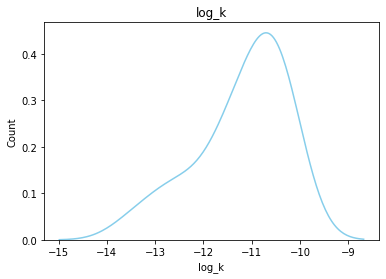

In [26]:
sns.kdeplot(data=snake_parameters, x="log_k", color="skyblue")
plt.title("log_k")
plt.xlabel("log_k")
plt.ylabel("Count")

In [46]:
# texas = snake_parameters['Study_Site'] == 'Texas-Marathon'
# canada = snake_parameters['Study_Site'] == 'Canada'
# nebraska = snake_parameters['Study_Site'] == 'Nebraska'
# #sns.kdeplot(data=snake_parameters[filtered_sites], x="log_k", hue="Study_Site", legend = True)
# sns.kdeplot(x=snake_parameters[texas]['log_k'], label='Texas', fill=True)
# sns.kdeplot(x=snake_parameters[canada]['log_k'], label='Canada', fill=True)
# sns.kdeplot(x=snake_parameters[nebraska]['log_k'], label='Nebraska', fill=True)
# plt.title("log_k by Study Site")
# plt.xlabel("log_k")
# plt.ylabel("Frequency")

# plt.legend()

# # Adjust layout
# plt.tight_layout()

# # Show the plot
# plt.show()


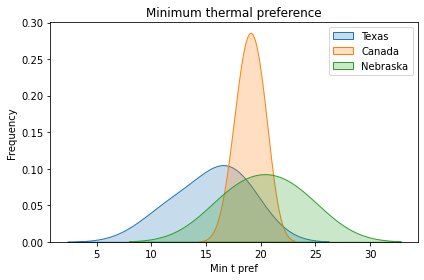

In [34]:
texas = snake_parameters['Study_Site'] == 'Texas-Marathon'
canada = snake_parameters['Study_Site'] == 'Canada'
nebraska = snake_parameters['Study_Site'] == 'Nebraska'
bw =1
#sns.kdeplot(data=snake_parameters[filtered_sites], x="log_k", hue="Study_Site", legend = True)
sns.kdeplot(x=snake_parameters[texas]['t_pref_min'],
            fill=True, cmap='Blues', label='Texas', bw_method=bw)
sns.kdeplot(x=snake_parameters[canada]['t_pref_min'],
            fill=True, cmap='Oranges', label='Canada', bw_method=bw)
sns.kdeplot(x=snake_parameters[nebraska]['t_pref_min'],
            fill=True, cmap='Greens', label='Nebraska', bw_method=bw)
plt.title("Minimum thermal preference")
plt.xlabel("Min t pref")
plt.ylabel("Frequency")

plt.legend()

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


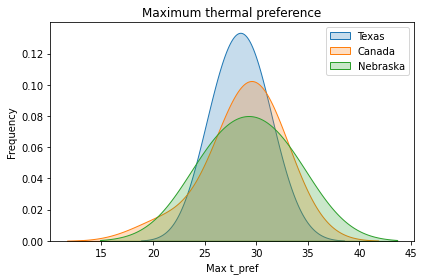

In [35]:
texas = snake_parameters['Study_Site'] == 'Texas-Marathon'
canada = snake_parameters['Study_Site'] == 'Canada'
nebraska = snake_parameters['Study_Site'] == 'Nebraska'
bw=1
#sns.kdeplot(data=snake_parameters[filtered_sites], x="log_k", hue="Study_Site", legend = True)
sns.kdeplot(x=snake_parameters[texas]['t_pref_max'],
            fill=True, cmap='Blues', label='Texas', bw_method=bw)
sns.kdeplot(x=snake_parameters[canada]['t_pref_max'],
            fill=True, cmap='Oranges', label='Canada', bw_method=bw)
sns.kdeplot(x=snake_parameters[nebraska]['t_pref_max'],
            fill=True, cmap='Greens', label='Nebraska', bw_method=bw)
plt.title("Maximum thermal preference")
plt.xlabel("Max t_pref")
plt.ylabel("Frequency")

plt.legend()

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


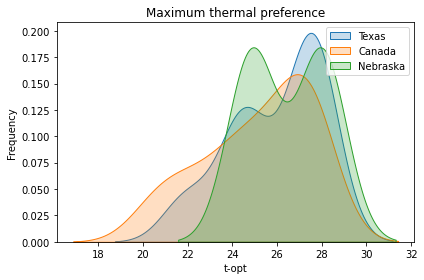

In [36]:
texas = snake_parameters['Study_Site'] == 'Texas-Marathon'
canada = snake_parameters['Study_Site'] == 'Canada'
bw=0.5
#sns.kdeplot(data=snake_parameters[filtered_sites], x="log_k", hue="Study_Site", legend = True)
sns.kdeplot(x=snake_parameters[texas]['t_opt'],
            fill=True, cmap='Blues', label='Texas', bw_method=bw)
sns.kdeplot(x=snake_parameters[canada]['t_opt'],
            fill=True, cmap='Oranges', label='Canada', bw_method=bw)
sns.kdeplot(x=snake_parameters[nebraska]['t_opt'],
            fill=True, cmap='Greens', label='Nebraska', bw_method=bw)
plt.title("Maximum thermal preference")
plt.xlabel("t-opt")
plt.ylabel("Frequency")

plt.legend()

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


In [37]:
#Save Parameters
snake_parameters.to_csv('ni_parameters_MMSE.csv', index=False)
#snake_parameters.to_csv('parameters_MMSE.csv', index=False)

In [12]:
# Simulate ectotherm Parameter Estimation
def in_out_binary(in_out_value):
    if in_out_value=='In':
        val = 0
    else:
        val = 1
    return val

# snakes['Date'] = pd.to_datetime(snakes['Date'])
# snakes['Year'] = snakes['Date'].dt.year
# snakes['Month'] = snakes['Date'].dt.month
# snakes['Day'] = snakes['Date'].dt.day
# snakes['Hour'] = snakes['Date'].dt.hour
# snakes['Minute'] = snakes['Date'].dt.minute

simulated_t_body = []
burrow_usage = []

snake_names = snakes['Snake_Name'].unique()

for snake in snake_names:
    condition1 = snakes['Snake_Name']==snake
    temp_df = snakes.loc[condition1]
    # Get Parameters
    para_condition = snake_parameters['Snake_Name']==snake
    temp_para = snake_parameters[para_condition]

    k=0.00005
    t_initial= 25
    t_pref_min = float(temp_para['t_pref_min'].iloc[0])
    t_pref_max = float(temp_para['t_pref_max'].iloc[0])
    t_opt = float(temp_para['t_opt'].iloc[0])
    #debounce = float(temp_para['debounce'].iloc[0])
    #Run Simulation
    ts = therma_sim.ThermalSimulator(flip_logic='preferred',
                                 t_pref_min=t_pref_min,
                                 t_pref_max=t_pref_max,
                                 t_pref_opt=t_opt, seed=42)
    ss_burrow_usage, tb_sim = ts.tb_simulator_2_state_model_wrapper(
                            k=k,
                            t_initial=t_initial,
                            burrow_temp_vector=temp_df['Burrow'],
                            open_temp_vector=temp_df['Open'],
                            return_tbody_sim=True)
    #temp_para = temp_para[temp_para['Burnin_Set']==1].reset_index(drop=True).drop('Burnin_Set', axis=1)
    burrow_usage.append(ss_burrow_usage)
    simulated_t_body.append(tb_sim)
    
burrow_usage = list(chain.from_iterable(burrow_usage))
simulated_t_body = list(chain.from_iterable(simulated_t_body))
    
snakes['Burrow_Usage'] = burrow_usage
snakes['tb_sim'] = simulated_t_body
snakes['Burrow_Usage_bool'] = [in_out_binary(i) for i in snakes['Burrow_Usage']]

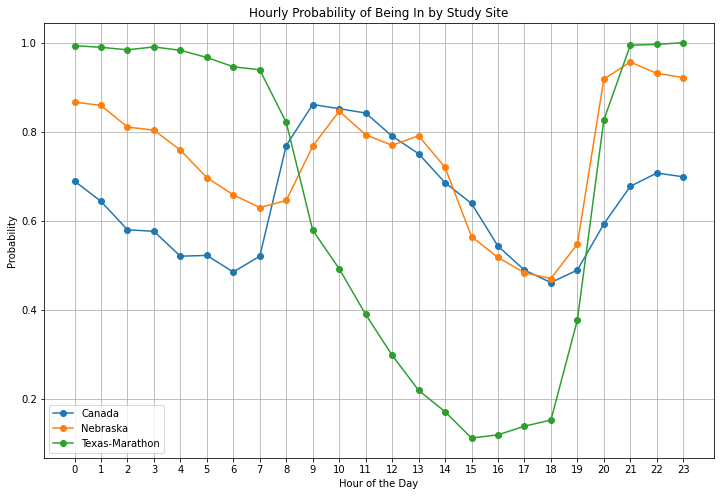

In [13]:
grouped_data = snakes.groupby(['Study_Site', 'Hour'])['Burrow_Usage_bool'].mean().reset_index()

# Plotting separate graphs for each study site
unique_sites = grouped_data['Study_Site'].unique()

plt.figure(figsize=(12, 8))

for site in unique_sites:
    site_data = grouped_data[grouped_data['Study_Site'] == site]
    plt.plot(site_data['Hour'], site_data['Burrow_Usage_bool'], marker='o', label=site)

plt.title('Hourly Probability of Being In by Study Site')
plt.xlabel('Hour of the Day')
plt.ylabel('Probability')
plt.xticks(range(24))
plt.legend()
plt.grid(True)
plt.show()

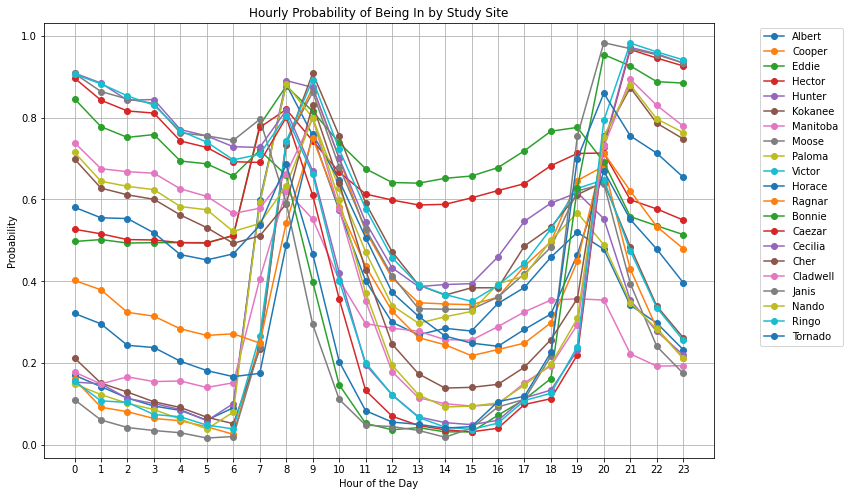

In [53]:
grouped_data = snakes.groupby(['Study_Site','Snake_Name', 'Hour'])['Burrow_Usage_bool'].mean().reset_index()

# Plotting separate graphs for each study site
unique_sites = snakes['Snake_Name'].unique()

plt.figure(figsize=(12, 8))

for site in unique_sites:
    site_data = grouped_data[grouped_data['Snake_Name'] == site]
    plt.plot(site_data['Hour'], site_data['Burrow_Usage_bool'], marker='o', label=site)

plt.title('Hourly Probability of Being In by Study Site')
plt.xlabel('Hour of the Day')
plt.ylabel('Probability')
plt.xticks(range(24))
plt.legend(bbox_to_anchor=[1.2, 1], loc='upper right')
plt.grid(True)
plt.show()

In [27]:
val_fp = 'training_data/validation.csv'
val = pd.read_csv(val_fp)
val.head()

,Snake_ID,Date,Time,Lat,Long,Photos,Behavior,Check,Notes,Snake_Name,In_Out_Burrow,Burrow_Label,datetime,year,month,day,hour,minute,rounded_minute
0,MGCRVI022,2021-07-14,18:33:00,30.298535,-103.147030,N,not visible,NaN,prairie dog burrow,Pius,1,In,2021-07-14 18:33:00,2021,7,14,18,33,30
1,MGCRVI022,2021-07-15,02:01:00,30.329856,-103.146988,N,not visible,NaN,inactive dog burrow,Pius,1,In,2021-07-15 02:01:00,2021,7,15,2,1,0
2,MGCRVI022,2021-07-16,00:22:00,30.298281,-103.146637,N,not visible,NaN,inactive dog burrow,Pius,1,In,2021-07-16 00:22:00,2021,7,16,0,22,20
3,MGCRVI022,2021-07-15,17:51:00,30.298535,-103.147030,N,not visible,NaN,inactive dog burrow,Pius,1,In,2021-07-15 17:51:00,2021,7,15,17,51,50
4,MGCRVI022,2021-07-16,13:33:00,30.298535,-103.147030,N,not visible,NaN,inactive dog burrow,Pius,1,In,2021-07-16 13:33:00,2021,7,16,13,33,30


In [28]:
sn_val = snakes.merge(val, left_on=['Snake_Name', 'Year', 'Month', 'Day', 'Hour'],
                      right_on =['Snake_Name', 'year', 'month', 'day', 'hour'], how='inner')
# sn_val_na = sn_val
# sn_val = sn_val.dropna(subset=['burrow_usage', 'In_Out_Burrow'])
sn_val.head()

,Study_Site,Snake_Name,Date_x,Body,Air,Open,Burrow,Year,Month,Day,...,Notes,In_Out_Burrow,Burrow_Label,datetime,year,month,day,hour,minute,rounded_minute
0,Texas-Marathon,Bonnie,2021-07-30 23:00:00,25.064,24.154000,19.789667,25.362000,2021,7,30,...,sporobolous,1,In,2021-07-30 23:51:00,2021,7,30,23,51,50
1,Texas-Marathon,Bonnie,2021-07-30 23:15:00,24.864,23.966127,19.609522,25.279884,2021,7,30,...,sporobolous,1,In,2021-07-30 23:51:00,2021,7,30,23,51,50
2,Texas-Marathon,Bonnie,2021-07-30 23:30:00,24.664,23.757654,19.501336,25.263283,2021,7,30,...,sporobolous,1,In,2021-07-30 23:51:00,2021,7,30,23,51,50
3,Texas-Marathon,Bonnie,2021-07-30 23:45:00,24.464,23.543118,19.424823,25.271058,2021,7,30,...,sporobolous,1,In,2021-07-30 23:51:00,2021,7,30,23,51,50
4,Texas-Marathon,Bonnie,2021-07-30 23:00:00,25.064,24.154000,19.789667,25.362000,2021,7,30,...,sporobolous,1,In,2021-07-30 23:51:00,2021,7,30,23,51,50


In [121]:
len(sn_val)

1104

In [29]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
tn, fp, fn, tp = confusion_matrix(y_true = sn_val['Burrow_Label'], y_pred = sn_val['Burrow_Usage']).ravel()
print(f'True Positives:{tp}')
print(f'True Negatives:{tn}')
print(f'False Positives:{fp}')
print(f'False Negatives:{fn}')

True Positives:236
True Negatives:345
False Positives:415
False Negatives:108


In [30]:
def accuracy(true_positive, true_negative, false_positive, false_negative):
    total = true_positive + true_negative + false_positive + false_negative
    correct = true_positive + true_negative
    return correct / total

def precision(true_positive, false_positive):
    if true_positive + false_positive == 0:
        return 0  # Avoid division by zero
    return true_positive / (true_positive + false_positive)

def recall(true_positive, false_negative):
    if true_positive + false_negative == 0:
        return 0  # Avoid division by zero
    return true_positive / (true_positive + false_negative)

print(f'Accuracy {accuracy(true_positive=tp, true_negative=tn, false_positive=fp, false_negative=fn)}')
print(f'Precision {precision(true_positive=tp, false_positive=fp)}')
print(f'Recall {recall(true_positive=tp, false_negative=fn)}')

Accuracy 0.5262681159420289
Precision 0.36251920122887865
Recall 0.686046511627907


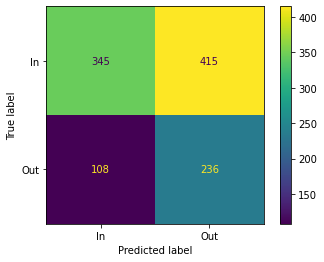

In [31]:
cm = confusion_matrix(y_true = sn_val['Burrow_Label'], y_pred = sn_val['Burrow_Usage'], labels=['In', 'Out'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=['In', 'Out'])
disp.plot()

plt.show()

In [41]:
sn_val['In_Out_Burrow'].head()

0    1
1    1
2    1
3    1
4    1
Name: In_Out_Burrow, dtype: int64

In [43]:
sn_val['Study_Site'].unique()

array(['Texas-Marathon'], dtype=object)

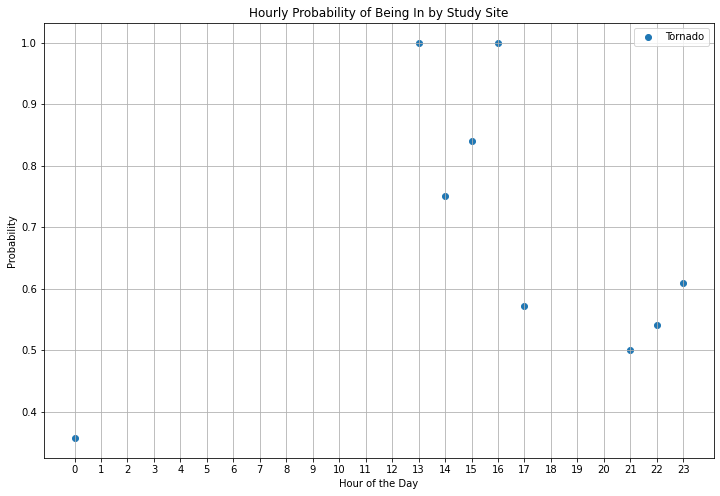

In [32]:
grouped_data = sn_val.groupby(['Study_Site', 'Hour'])['In_Out_Burrow'].mean().reset_index()

# Plotting separate graphs for each study site
#unique_sites = sn_val['Study_Site'].unique()

plt.figure(figsize=(12, 8))


plt.scatter(grouped_data ['Hour'], grouped_data ['In_Out_Burrow'], marker='o', label=site)

plt.title('Hourly Probability of Being In by Study Site')
plt.xlabel('Hour of the Day')
plt.ylabel('Probability')
plt.xticks(range(24))
plt.legend()
plt.grid(True)
plt.show()

In [33]:
### State Flips

def state_flips(values):
    result = [0]  # The first value always has no previous value to compare
    for i in range(1, len(values)):
        if values[i] != values[i - 1]:
            result.append(1)
        else:
            result.append(0)
    return result


df['State_Flips'] = state_flips(df['burrow_usage'])
rolling_sum = df['State_Flips'].rolling(window=10).sum()

# Add the rolling sum as a new column to the DataFrame
df['Rolling_Sum'] = rolling_sum

NameError: name 'df' is not defined